In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import oracledb

In [6]:
dsn = oracledb.makedsn("dbhost.students.cs.ubc.ca", 1522, service_name="stu")
connection = oracledb.connect(user="ora_ahoang05", password="a44232551", dsn=dsn)
cursor = connection.cursor()
print("Connected!")

Connected!


## Research Question 1:
How have U.S healthcare expenditures evolved over the years, and which categories have contributed most significantly to the changes? 

#### Overall Insights & Relevance to Research Questions

1. **Time Coverage**  
   - **NHE Tables 1, 2, 3** each contain 26 rows, covering roughly **1980–2023**, while **Table 5** has 37 rows (1987–2023).  
   - This indicates partial coverage: you may have fewer overlapping years when merging with IHME data (which spans 1980–2021).

2. **Expenditure Growth**  
   - Across all tables, total health expenditures have **increased substantially** over time, from as low as $\$253.2$ billion (1980) to nearly $\$4.9$ trillion (2023).  
   - Subcategories (e.g., hospital care, physician services, prescription drugs) and sources of funds (Medicare, Medicaid, private) also show significant growth patterns.

3. **Type of Sponsor** (Table 5)  
   - Shows how **government vs. private** sponsorship has evolved, which could be relevant if you’re exploring whether **financing mechanisms** correlate with disease outcomes.

4. **Potential for Correlation**  
   - Given the **rising expenditures** in different categories, you can investigate if **increases** in specific spending types (e.g., hospital care) are linked to **reduced mortality** in particular diseases (from IHME).

5. **Data Quality**  
   - All tables show **no missing values** in their numeric columns, simplifying merges and subsequent analysis.

6. **Relevance to Research Questions**  
   - **Question 1** (Overall spending vs. mortality):  
     - Tables 1 and 2 (which detail total and category-level spending) can be merged with IHME data on `year` to see if higher total spending aligns with changes in overall mortality or disease rates.

     - The **breakdowns** in Table 2 (type of service), Table 3 (source of funds), and Table 5 (sponsor type) allow a deeper dive into which expenditures might correlate most strongly with certain diseases in IHME.


Since each row in our tables represents a single year and we only have one data point per year for each expenditure or disease metric, a histogram or box plot can still show basic distribution and detect outliers—but we’ll have very few data points (e.g., 26 or 37). In that case, it’s often more insightful to treat these variables as time series and use line plots or time-series methods (e.g., trend analysis, correlation over time) to see how they evolve year by year - which is the method that we have decided to go with.


### Part 1: How have U.S healthcare expenditures evolved over the years

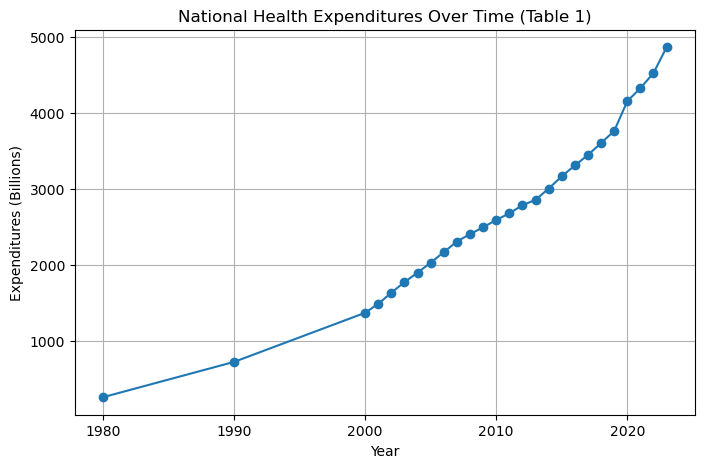

In [15]:
cursor.execute("""SELECT Year, Nations_Health_Expenditures_Billions 
                  FROM TotalExpenditure""")

expenditure_by_time = pd.DataFrame(cursor.fetchall(), columns=["year", "expenditure"])

expenditure_by_time = expenditure_by_time.sort_values("year")

plt.figure(figsize=(8,5))
plt.plot(expenditure_by_time["year"], expenditure_by_time["expenditure"], marker='o')
plt.title("National Health Expenditures Over Time (Table 1)")
plt.xlabel("Year")
plt.ylabel("Expenditures (Billions)")
plt.grid(True)
plt.show()

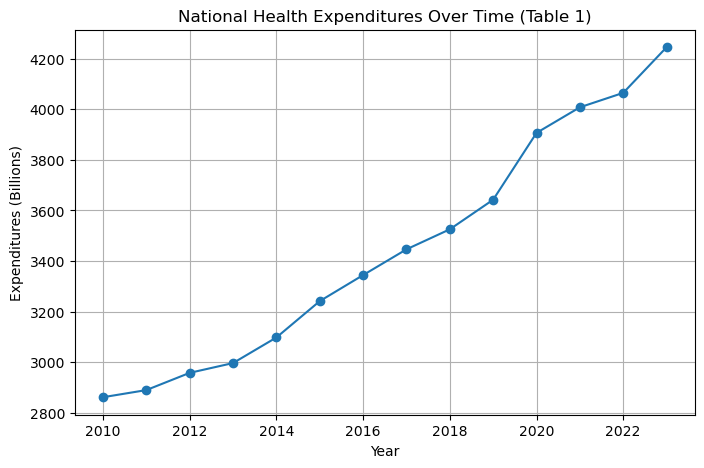

In [28]:
cursor.execute("""SELECT year, National_Health_Expenditures_Billions 
                  FROM TotalExpenditureInRealDollars
                  ORDER BY year""")

expenditure_by_time_real = pd.DataFrame(cursor.fetchall(), columns=["year", "expenditure"])

plt.figure(figsize=(8,5))
plt.plot(expenditure_by_time_real["year"], expenditure_by_time_real["expenditure"], marker='o')
plt.title("National Health Expenditures Over Time (Table 1)")
plt.xlabel("Year")
plt.ylabel("Expenditures (Billions)")
plt.grid(True)
plt.show()

#### Comparison of Nominal vs. Real Dollar Expenditures

From the two plots:

1. **Nominal Expenditures (Table 1)**  
   - Shows a **steady upward trend** from roughly $\$253.2$ billion in **1980** to almost **$\$5$ trillion** by **2023**.  
   - The growth appears **smooth** and fairly **consistent** across the years, reflecting **both** true increases in health spending and **inflation** over time.

2. **Real Dollar Expenditures**  
   - Adjusted for inflation (e.g., to a constant year’s value).  
   - Remains **relatively flat** until around **2010s**, then **accelerates sharply** afterwords, reaching around **\$4.2 trillion** in 2023.  
   - This indicates that **even in constant dollars**, health expenditures have **increased significantly** since the early 2010s—just not as steadily as the nominal curve suggests.

### Key Observations

- **Inflation Effect**:  
  - The nominal plot rises more **gradually** (due to compounding inflation), whereas the real-dollar plot remains **lower** and more **compressed** in earlier decades, then **surges** later.  
  - This highlights how **inflation** can mask or exaggerate certain spending patterns when looking at raw dollars over multiple decades.

- **Implications for Analysis**:  
  - Using **nominal** dollars can overstate growth caused by **price inflation** rather than actual increases in **resource allocation**.  
  - **Real** dollars provide a **truer** sense of how much more (or less) healthcare resources are consumed over time.

- **Relevance to Research Questions**:  
  1. **Overall Spending vs. Mortality (Q1)**:  
     - Analyzing **real** expenditures might give a clearer picture of whether true resource increases correlate with changes in mortality.  
  2. **Subcategories and Specific Diseases (Q2)**:  
     - When comparing different spending types (e.g., hospital care, prescription drugs) to disease outcomes, using **real dollars** ensures a **fair comparison** across years.

In summary, **both** plots confirm the **major growth** in U.S. health expenditures, but the **real-dollar** plot is often more **reliable** for long-term trend analysis, avoiding the confounding effects of inflation.  


### Part 2: Which categories have contributed most significantly to the changes? 

In [23]:
query = """SELECT t.year,
                  t.National_Health_Expenditures_Billions AS expenditure, 
                  d.death_count
           FROM TotalExpenditureInRealDollars t
           INNER JOIN (
                       SELECT year, SUM(mean) AS death_count
                       FROM Disease
                       WHERE measure_name = 'Deaths'
                       GROUP BY year
                    ) d ON t.year = d.year
           ORDER BY t.year"""

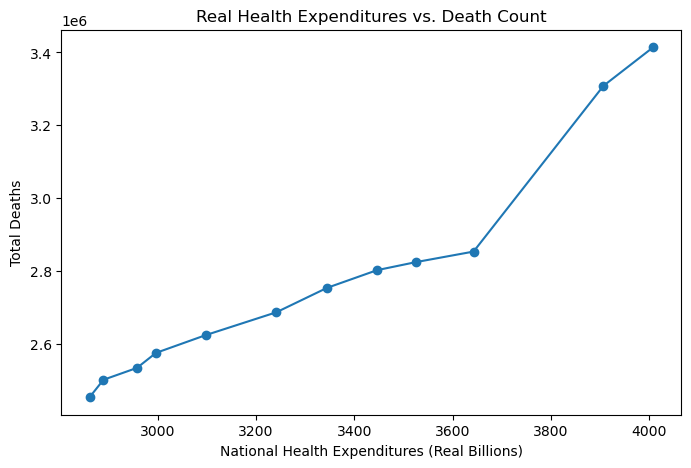

In [33]:
cursor.execute(query)
expenditure_by_death = pd.DataFrame(cursor.fetchall(), columns=['year','expenditure', 'death_count'])

plt.figure(figsize=(8,5))
plt.plot(expenditure_by_death["expenditure"], expenditure_by_death["death_count"], marker='o')
plt.title("Real Health Expenditures vs. Death Count")
plt.xlabel("National Health Expenditures (Real Billions)")
plt.ylabel("Total Deaths")

plt.show()

#### Observations: Real Health Expenditures vs. Death Count

1. **Positive Relationship**  
   - As real health expenditures increase (x-axis), death count (y-axis) also rise, suggesting a **positive correlation** in this dataset.
   - The scatter points form a generally **upward-sloping** trend, indicating that years with higher spending also have higher death count.

2. **Axis Scaling**  
   - The x-axis ranges from **0 to ~12**—likely reflecting **trillions** of real dollars in a simplified scale or a transformed unit.  
   - The y-axis spans roughly $2.0\times×10^6$ to **$3.4\times10^6$** death count, showing an increase of around **1.4 million** deaths across the plotted time frame.

3. **Possible Explanations**  
   - **Population Growth**: As the U.S. population grows, both total spending and death count can rise in tandem.  
   - **Aging Demographics**: An older population often leads to higher death counts and increased healthcare spending.  
   - **Inflation Adjustment**: These expenditures are in **real (inflation-adjusted)** dollars, so the growth represents true increases in resource allocation rather than just price inflation.

4. **Limitations & Next Steps**  
   - **Correlation ≠ Causation**: A higher spending year does not necessarily *cause* more deaths. External factors (e.g., population size, disease prevalence) likely drive both spending and mortality trends.  
   - **Normalized Measures**: You might consider **per capita** expenditures or **age-standardized** mortality rates for a clearer insight into how spending tracks with health outcomes independent of population changes.  
   - **Subcategory Analysis**: If **Question 2** involves specific expenditure types (e.g., hospital care, prescription drugs), plotting them individually against cause-specific mortality may offer deeper insight.

Overall, this plot confirms a **positive association** between real health expenditures and death count over time, highlighting the complexity of interpreting healthcare spending trends alongside mortality.  


**Let's Examine the deaths caused by each disease to have a better idea on how it effects expenditure**

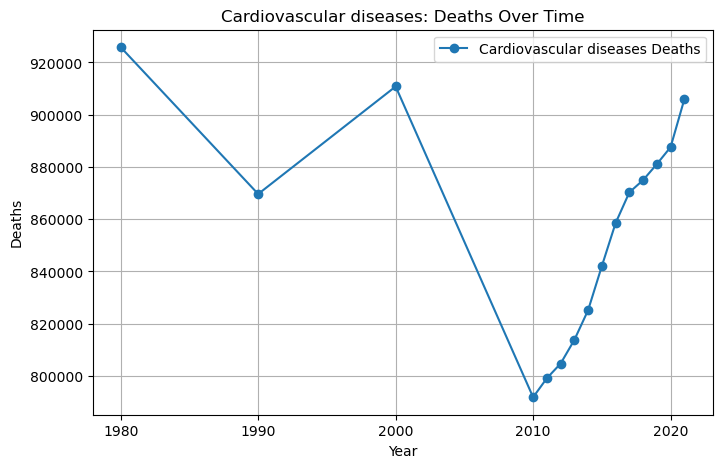

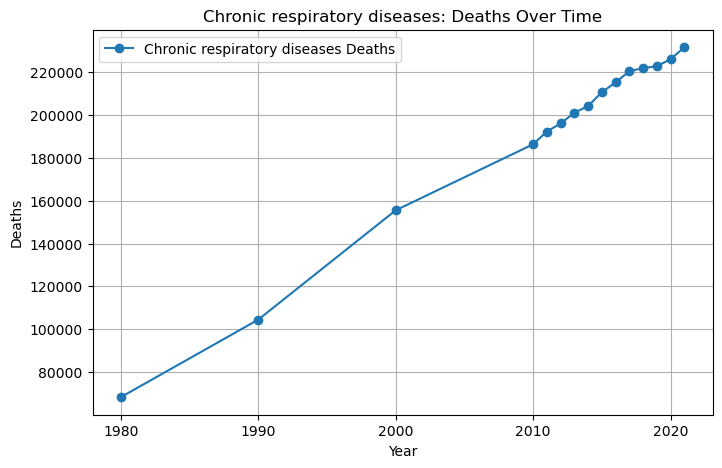

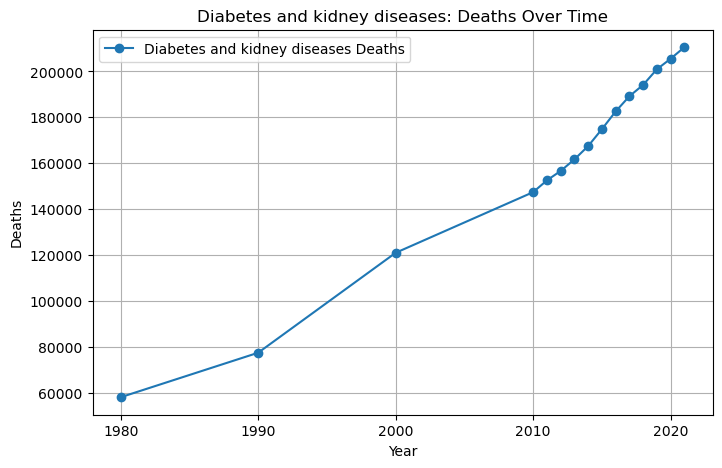

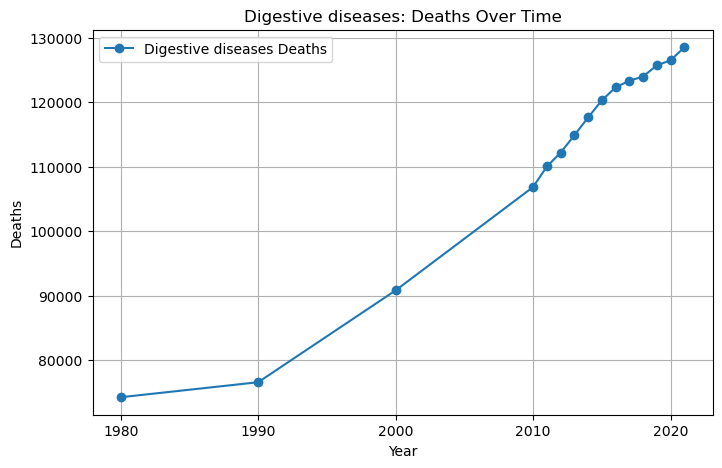

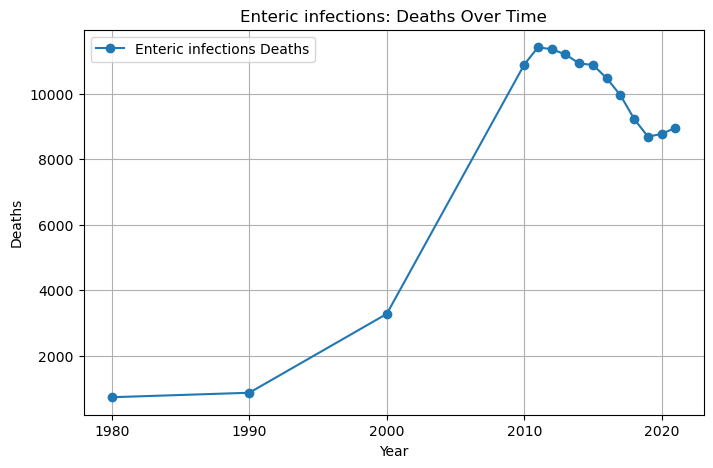

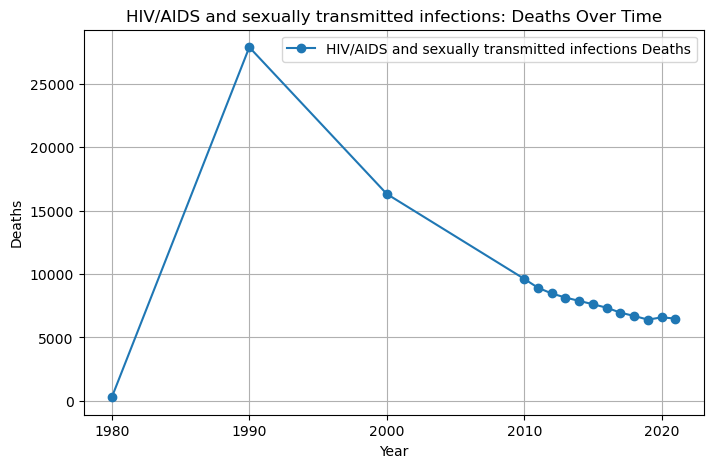

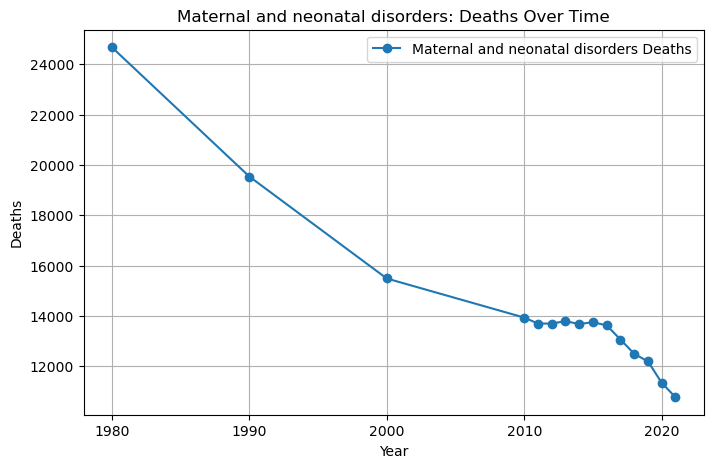

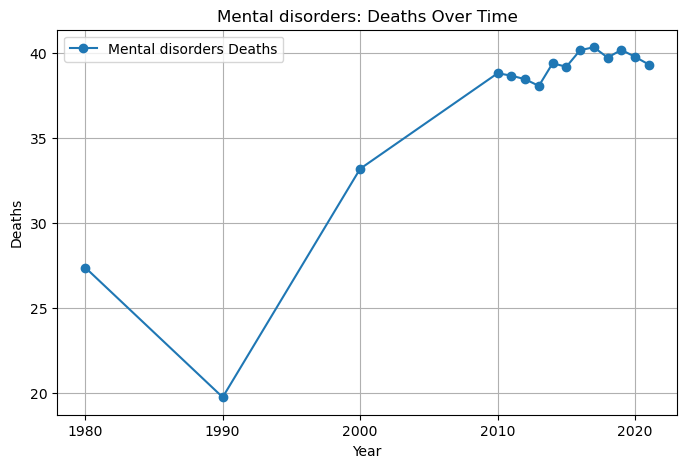

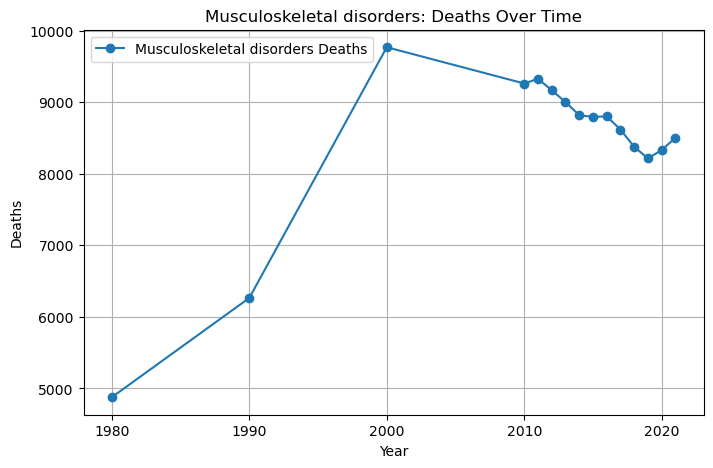

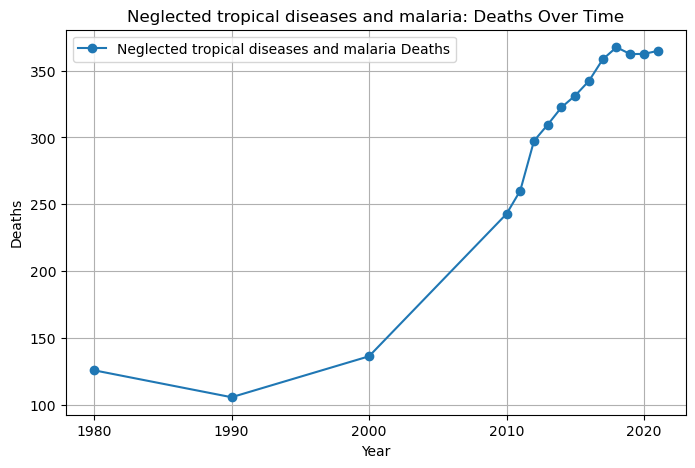

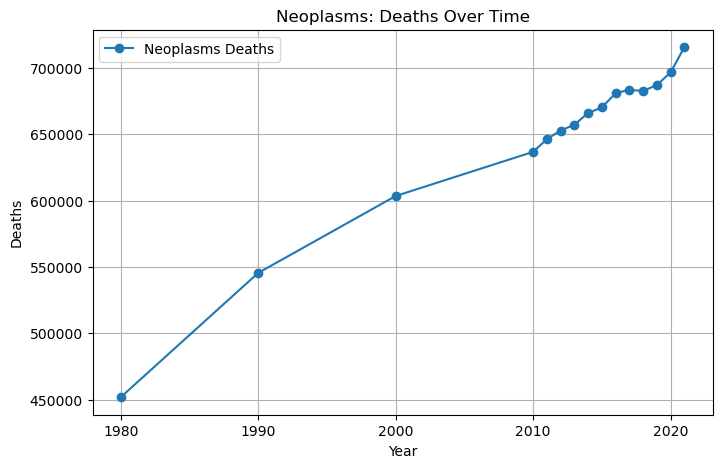

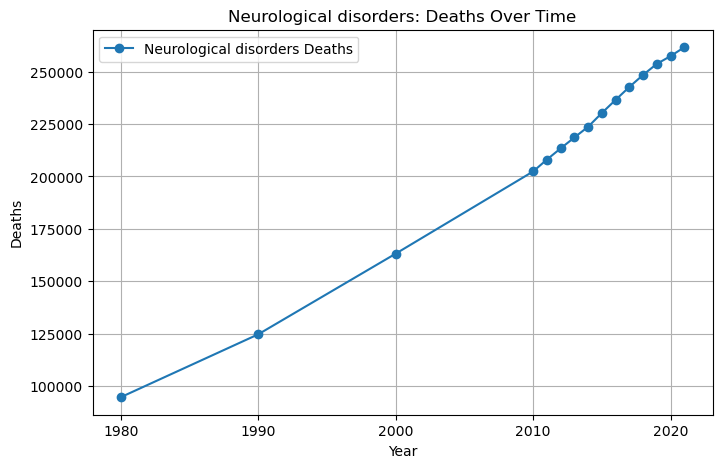

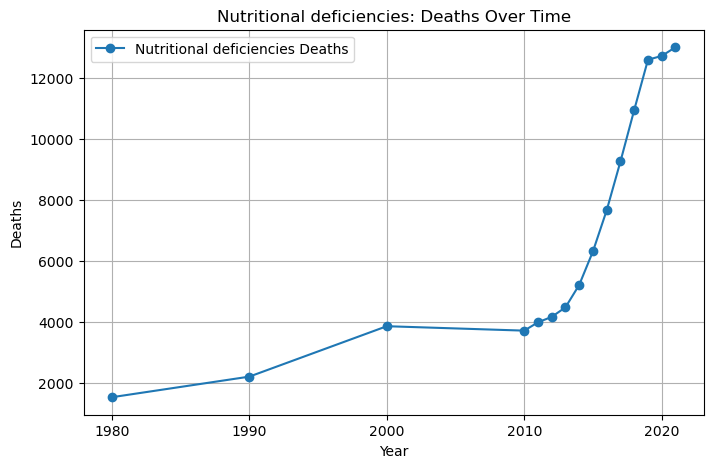

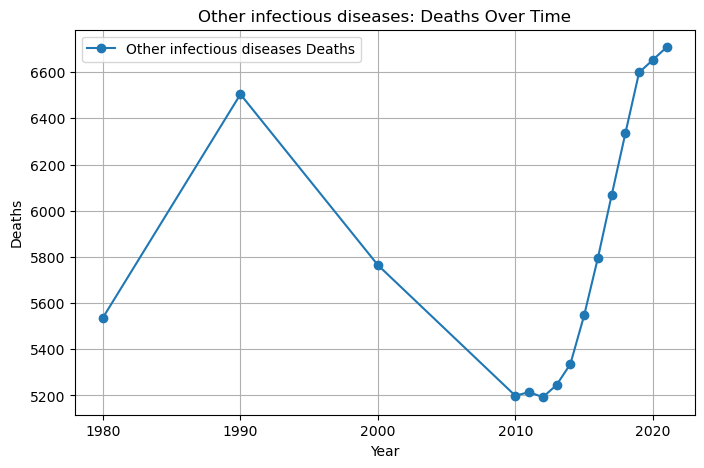

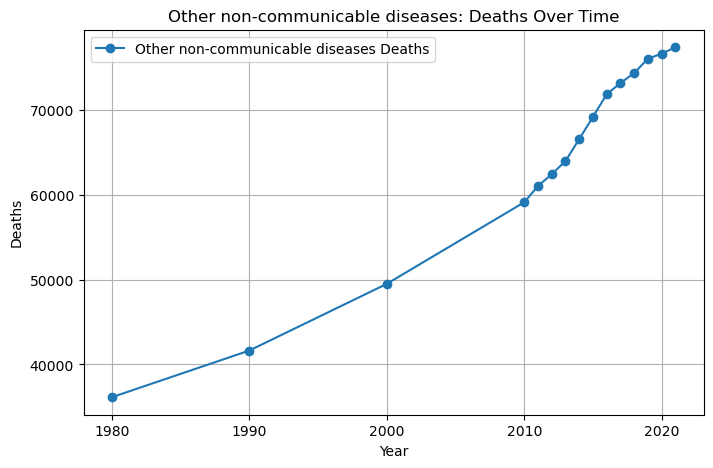

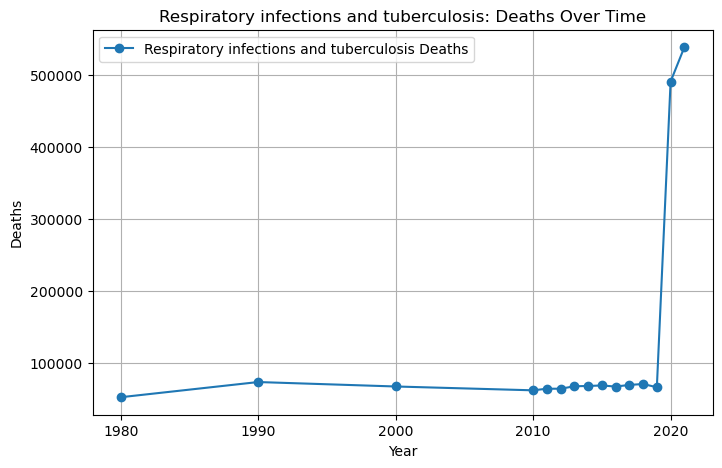

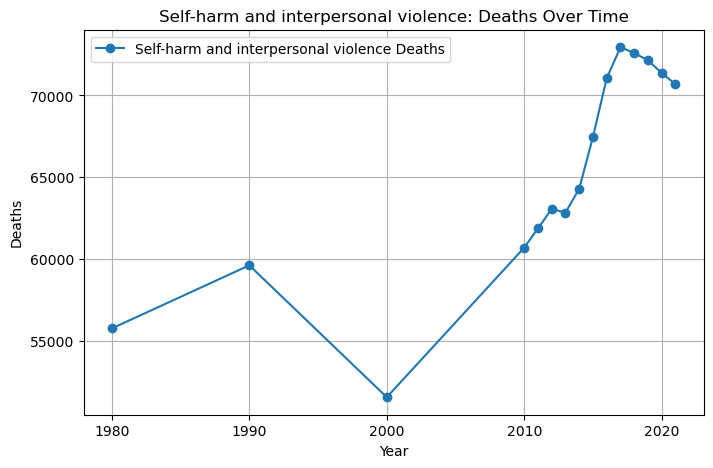

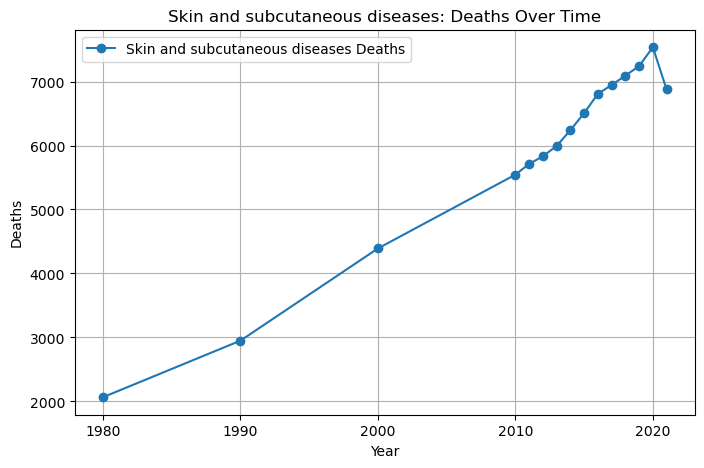

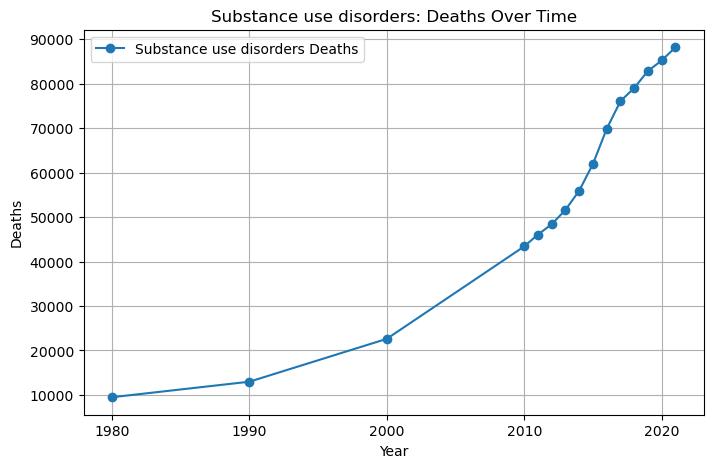

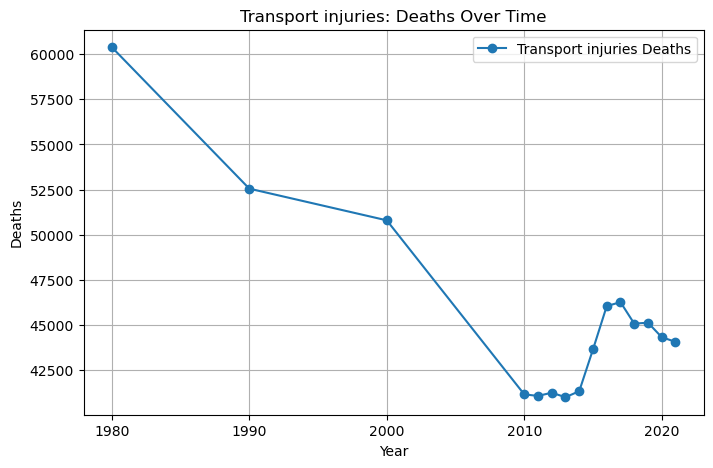

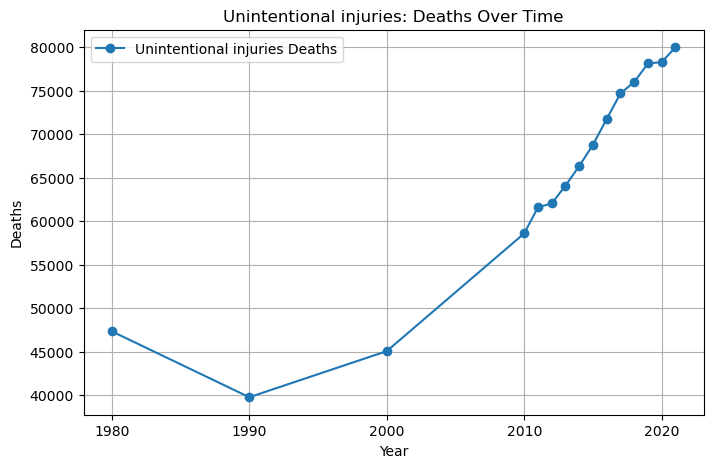

In [47]:
query = """
SELECT d.year,
       d.cause_name,
       SUM(d.mean) AS death_count,
       t.National_Health_Expenditures_Billions AS expenditure
FROM Disease d
INNER JOIN TotalExpenditureInRealDollars t
    ON d.year = t.year
WHERE d.measure_name = 'Deaths'
GROUP BY d.year, d.cause_name, t.National_Health_Expenditures_Billions
ORDER BY d.cause_name, d.year
"""
cursor.execute(query)
death_by_disease = pd.DataFrame(cursor.fetchall(), columns=["year", "cause_name", "Deaths", "expenditure"])

for disease in death_by_disease["cause_name"].unique():
    df_disease = death_by_disease[death_by_disease["cause_name"] == disease].copy()
    
    plt.figure(figsize=(8,5))
    plt.plot(df_disease["year"], df_disease["Deaths"], marker='o', label=f"{disease} Deaths")
    plt.title(f"{disease}: Deaths Over Time")
    plt.xlabel("Year")
    plt.ylabel("Deaths")
    plt.grid(True)
    plt.legend()
    plt.show()

## Brief Summary of Disease-Specific Mortality Trends (1980–2020+)

That was a lot of data so here is a concise overview of the death trends for various diseases, grouped by **similar patterns**. These are **absolute death counts**, not rates, so population growth and demographic shifts can affect these numbers.

---

### 1. Diseases Showing Strong, Mostly Continuous Rise

- **Neoplasms (Cancer)**  
  - ~450k in 1980 → 700k+ by 2020s  
  - Reflects an aging population and possibly lifestyle factors; improved treatments may moderate death *rates*.

- **Diabetes & Kidney Diseases**  
  - ~60k in 1980 → 200k+ by 2020  
  - Significant increase in diabetes prevalence, possibly linked to obesity and other metabolic factors.

- **Digestive Diseases**  
  - ~70k in 1980 → 130k+ by 2020  
  - Gradual climb, could be influenced by diet, alcohol use, or aging demographics.

- **Neurological Disorders**  
  - ~100k in 1980 → 250k+ by 2020  
  - Includes Alzheimer’s and other dementias, which rise with longer life spans.

- **Chronic Respiratory Diseases**  
  - ~70k → 220k+  
  - Long-term growth, often linked to smoking and air pollution.

- **Substance Use Disorders**  
  - ~10k → 90k+  
  - Steep climb, may reflect opioid crises and broader substance issues in recent decades.

- **Skin & Subcutaneous Diseases**  
  - ~2k → 7k+  
  - Smaller absolute numbers but a clear upward trend.

---

### 2. U-Shaped Parabolic Patterns

- **Cardiovascular Diseases**  
  - ~920k in 1980, dips ~790k in early 2000s, then back to ~920k  
  - Initial improvements (better treatment/prevention) followed by a rebound, possibly due to obesity and other risk factors.

- **Unintentional Injuries**  
  - ~50k in 1980 → 35k in 2000 → 80k by 2020  
  - Early decline suggests improved safety measures; recent surge might be linked to drug overdoses or other factors.

- **Self-Harm & Interpersonal Violence**  
  - ~55k in 1980, dips ~50k by 2000, climbs ~70k, then slight drop  
  - Fluctuations may reflect social, economic, or policy changes around violence and suicide prevention.

- **Transport Injuries**  
  - ~60k in 1980 → ~40k in ~2010 → ~45k+ by 2020  
  - Safety improvements initially reduced deaths; partial rebound in recent years.

---

### 3. Mostly Downward Trends

- **Maternal & Neonatal Disorders**  
  - ~24k in 1980 → ~12k by 2020  
  - Suggests effective maternal health interventions.

- **HIV/AIDS & STIs**  
  - Peaks ~25k in 1990, then a sharp decline to a few thousand by 2010s  
  - Reflects successful antiretroviral treatments and public health campaigns.

---

### 4. Complex or Fluctuating Patterns

- **Neglected Tropical Diseases & Malaria**  
  - Mild dip in 1980s, rises post-2000 (~350+), slight plateau  
  - Possibly affected by funding changes, global eradication efforts, and data improvements.

- **Respiratory Infections & Tuberculosis**  
  - Fairly stable until ~2010, then a huge spike (~500k)  
  - Could indicate new data/reporting changes or specific outbreaks.

- **Enteric Infections**  
  - A few thousand in 1980, up to ~12k by 2010, mild decline afterward  
  - Reflects evolving sanitation, population growth, and possible outbreak cycles.

- **Other Infectious Diseases**  
  - Dip in 1990s, resurgence post-2000 (6k+), partial leveling  
  - May reflect new emerging infections or improved reporting.

- **Musculoskeletal Disorders**  
  - 5k in 1980 → 10k by 2000, then down to ~8k, slight rebound  
  - Possibly improved treatments, followed by demographic shifts (aging population).

- **Mental Disorders**  
  - Very low absolute values (tens of deaths), big drop ~1990, then ~35–40 from 2005+  
  - Could be classification or reporting changes; typically not direct cause of death except in special cases.

- **Nutritional Deficiencies**  
  - ~2k until ~2000, then jumps to ~12k by 2020  
  - Potentially a reflection of socio-economic factors or data changes in recent years.

---

### Overall Takeaways

1. **Rising Chronic Diseases**  
   - Cancer, diabetes, neurological, and chronic respiratory conditions show notable absolute death growth, consistent with global aging and lifestyle factors.

2. **Success Stories**  
   - HIV/AIDS and maternal/neonatal mortality have dropped significantly, indicating **effective interventions**.

3. **Rebounds & Resurgences**  
   - Cardiovascular diseases, unintentional injuries, and some infectious diseases show early improvements followed by a renewed climb—highlighting **complex** health challenges.

4. **Data & Demographic Influences**  
   - Absolute death counts are **not age-standardized**; some spikes may result from **population growth**, **shifts in demographics**, or **methodological changes** in data collection.

In summary, the dataset reveals **diverse** mortality trajectories across diseases—some with clear progress, others with worrisome upticks—reflecting the **shifting landscape** of public health challenges over the last four decades.


In [5]:
connection.close()